In [ ]:
import os, sys
import time

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from tqdm.notebook import tqdm

from sklearn.preprocessing import MinMaxScaler

# Define data root directory
data_dir = "/content/drive/MyDrive"
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# class for blocking print statements
class HiddenPrints:
    def __enter__(self):
        self._original_stdout = sys.stdout
        sys.stdout = open(os.devnull, 'w')

    def __exit__(self, exc_type, exc_val, exc_tb):
        sys.stdout.close()
        sys.stdout = self._original_stdout

In [ ]:
pd.read_csv('/content/Xtrain.csv').head()

,0
0,86
1,141
2,95
3,41
4,22


In [ ]:
scaler = {}
train_x = []
test_x = {}
test_y = {}

    
# Store csv file in a Pandas DataFrame
df = pd.read_csv('/content/Xtrain.csv')

# Scaling the input data
sc = MinMaxScaler()
# fit transform scales the data
scaler[0] = sc.fit(df.values)
# fit calculates min and max to scale back
data = sc.transform(df.values)

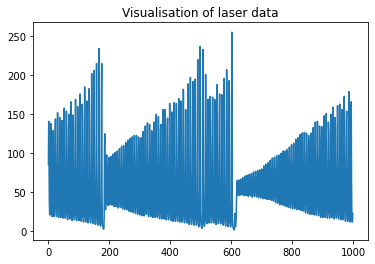

In [ ]:
plt.title('Visualisation of laser data')
plt.plot(df)
plt.rcParams["figure.figsize"] = (12,10)
plt.show()

In [ ]:
class GRUNet(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, n_layers, drop_prob=0.2):
        super(GRUNet, self).__init__()
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers        
        self.gru = nn.GRU(input_dim, hidden_dim, n_layers, batch_first=True, dropout=drop_prob)
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.relu = nn.ReLU()
        
    def forward(self, x, h):
        out, h = self.gru(x, h)
        out = self.fc(self.relu(out[:,-1]))
        return out, h
    
    def init_hidden(self, batch_size):
        weight = next(self.parameters()).data
        hidden = weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().to(device)
        return hidden

In [ ]:
def train(train_loader, learn_rate, hidden_dim=256, EPOCHS=20):

    input_dim = next(iter(train_loader))[0].shape[2]
    output_dim = 1
    n_layers = 2

    model = GRUNet(input_dim, hidden_dim, output_dim, n_layers)

    model.to(device)
    
    # Defining loss function and optimizer
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learn_rate)
    
    model.train()

    epoch_times = []
    # Start training loop
    for epoch in range(1,EPOCHS+1):
        start_time = time.time()
        h = model.init_hidden(batch_size)
        avg_loss = 0.
        counter = 0
        for x, label in train_loader:
            counter += 1

            h = h.data
            model.zero_grad()
            
            out, h = model(x.to(device).float(), h)
            loss = criterion(out, label.to(device).float())
            loss.backward()
            optimizer.step()
            avg_loss += loss.item()
            if counter%200 == 0:
                print("Epoch {}......Step: {}/{}....... Average Loss for Epoch: {}".format(epoch, counter, len(train_loader), avg_loss/counter))
        current_time = time.time()
        print("Epoch {}/{} Done, Total Loss: {}".format(epoch, EPOCHS, avg_loss/len(train_loader)))
        print("Time Elapsed for Epoch: {} seconds".format(str(current_time-start_time)))
        epoch_times.append(current_time-start_time)
    print("Total Training Time: {} seconds".format(str(sum(epoch_times))))
    return model 

In [ ]:
def evaluate(model, test_x, test_y, label_scalers):
    model.eval()
    outputs = []
    targets = []

    for i in test_x.keys():
        inp = torch.from_numpy(np.array(test_x[i]))
        labs = torch.from_numpy(np.array(test_y[i]))
        h = model.init_hidden(inp.shape[0])
        out, h = model(inp.to(device).float(), h)
        outputs.append(label_scalers[i].inverse_transform(out.cpu().detach().numpy()).reshape(-1))
        targets.append(label_scalers[i].inverse_transform(labs.numpy()).reshape(-1))


    RMSE=0
    MSE =0
    MAE =0
    for i in range(len(outputs)):
        RMSE += np.sqrt(np.mean((outputs[i]-targets[i])**2))
        MSE += np.mean((outputs[i]-targets[i])**2)
        MAE += np.mean(np.abs(outputs[i]-targets[i]))
    print("RMSE: {}".format(RMSE))
    print("MSE: {}".format(MSE))
    print("MAE: {}".format(MAE))
    return outputs, targets, RMSE, MSE, MAE

In [ ]:
def predict(model, pred_x, pred_y, label_scalers):
    model.eval()
    outputs = []
    targets = []

    for i in pred_x.keys():
        inp = torch.from_numpy(np.array(pred_x[i]))
        labs = torch.from_numpy(np.array(pred_y[i]))
        h = model.init_hidden(inp.shape[0])
        out, h = model(inp.to(device).float(), h)
        outputs.append(label_scalers[i].inverse_transform(out.cpu().detach().numpy()).reshape(-1))
        targets.append(label_scalers[i].inverse_transform(labs.numpy()).reshape(-1))


    RMSE = 0
    MSE = 0
    MAE = 0
    for i in range(len(outputs)):
        RMSE += np.sqrt(np.mean((outputs[i]-targets[i])**2))
        MSE += np.mean((outputs[i]-targets[i])**2)
        MAE += np.mean(np.abs(outputs[i]-targets[i]))
    print("RMSE: {}".format(RMSE))
    print("MSE: {}".format(MSE))
    print("MAE: {}".format(MAE))
    return outputs, targets, RMSE, MSE, MAE

In [ ]:
is_cuda = torch.cuda.is_available()


if is_cuda:
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

In [ ]:
#effect of lookback on training performance 

perf =[]
for i in range(30,220,20):
  lookback = i

  inputs = np.zeros((len(data)-lookback,lookback,df.shape[1]))
  labels = np.zeros(len(data)-lookback)

  for i in range(lookback, len(data)):
    inputs[i-lookback] = data[i-lookback:i]
      
    labels[i-lookback] = data[i,0]

  inputs = inputs.reshape(-1,lookback,df.shape[1])
  labels = labels.reshape(-1,1)

  test_portion = int(0.1*len(inputs))
  if len(train_x) == 0:
    train_x = inputs[:-test_portion]
    train_y = labels[:-test_portion]

  test_x[0]= inputs[-test_portion:]
  test_y[0] = labels[-test_portion:]

  batch_size = 1

  train_data = TensorDataset(torch.from_numpy(train_x), torch.from_numpy(train_y))
  train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size, drop_last=True)


  lr = 0.001

  with HiddenPrints():
    gru_model = train(train_loader, lr)
    gru_outputs, targets, RMSE, MSE, MAE = evaluate(gru_model, test_x, test_y, scaler)
    
  perf.append([RMSE,MAE])

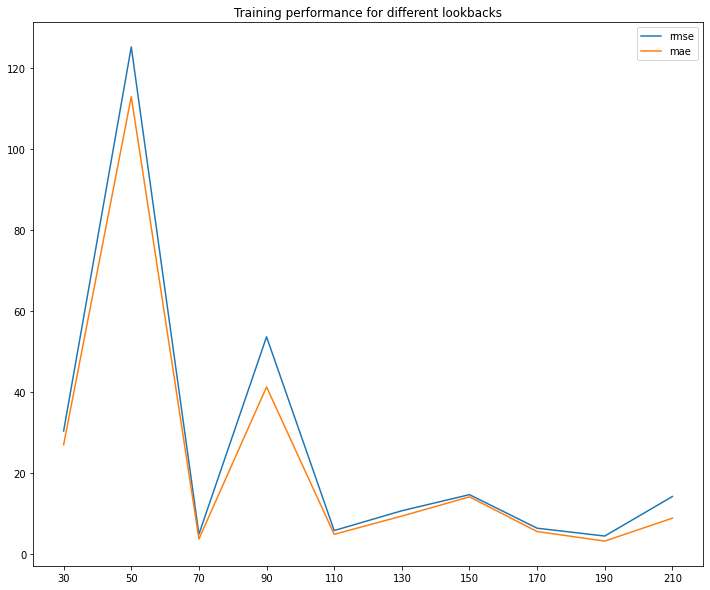

In [ ]:
plt.title('Training performance for different lookbacks')
p1=plt.plot([rmse[0] for rmse in perf])
p2=plt.plot([mae[1] for mae in perf])
plt.xticks(np.arange(0,10),np.arange(30,220,20))
plt.legend((p1[0], p2[0]), ('rmse', 'mae'))
plt.show()

In [ ]:
# Based on the above results lookback is taken as 70
lookback = 70

inputs = np.zeros((len(data)-lookback,lookback,df.shape[1]))
labels = np.zeros(len(data)-lookback)

for i in range(lookback, len(data)):

    inputs[i-lookback] = data[i-lookback:i]
      
    labels[i-lookback] = data[i,0]

inputs = inputs.reshape(-1,lookback,df.shape[1])
labels = labels.reshape(-1,1)

test_portion = int(0.1*len(inputs))
if len(train_x) == 0:
    train_x = inputs[:-test_portion]
    train_y = labels[:-test_portion]

test_x[0]= inputs[-test_portion:]
test_y[0] = labels[-test_portion:]

In [ ]:
batch_size = 1

train_data = TensorDataset(torch.from_numpy(train_x), torch.from_numpy(train_y))
train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size, drop_last=True)

In [ ]:
lr = 0.001
gru_model = train(train_loader, lr)

Epoch 1......Step: 200/873....... Average Loss for Epoch: 0.03558826643055646
Epoch 1......Step: 400/873....... Average Loss for Epoch: 0.028844459812684953
Epoch 1......Step: 600/873....... Average Loss for Epoch: 0.0221471775662646
Epoch 1......Step: 800/873....... Average Loss for Epoch: 0.018991916071589364
Epoch 1/20 Done, Total Loss: 0.017779451534759693
Time Elapsed for Epoch: 8.668904781341553 seconds
Epoch 2......Step: 200/873....... Average Loss for Epoch: 0.005008750048435644
Epoch 2......Step: 400/873....... Average Loss for Epoch: 0.005761502439585442
Epoch 2......Step: 600/873....... Average Loss for Epoch: 0.007573308101164251
Epoch 2......Step: 800/873....... Average Loss for Epoch: 0.006995189950078329
Epoch 2/20 Done, Total Loss: 0.0068974290966832
Time Elapsed for Epoch: 8.639359951019287 seconds
Epoch 3......Step: 200/873....... Average Loss for Epoch: 0.00761102212016259
Epoch 3......Step: 400/873....... Average Loss for Epoch: 0.006042319756943271
Epoch 3......Ste

In [ ]:
gru_outputs, targets,RMSE,MSE,MAE = evaluate(gru_model, test_x, test_y, scaler)

RMSE: 4.227740396906132
MSE: 17.87378886363202
MAE: 2.8821929603494625


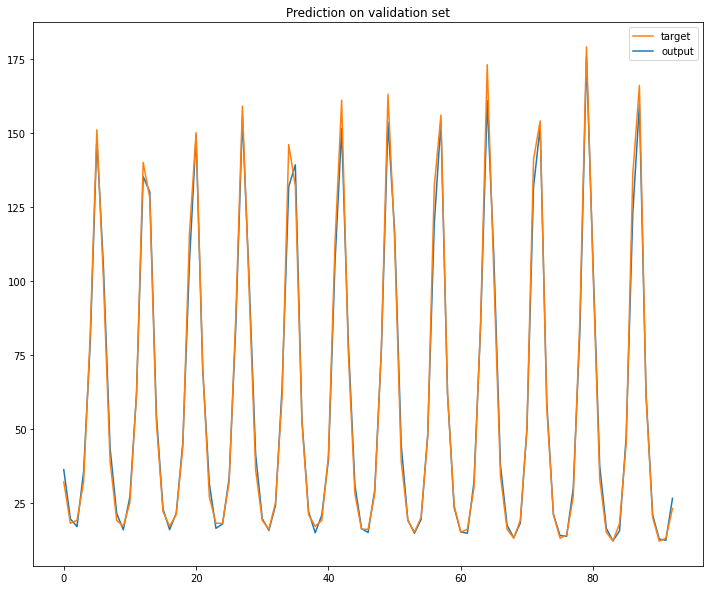

In [ ]:
plt.title('Prediction on validation set')
p2=plt.plot(gru_outputs[0])
p1=plt.plot(targets[0])
plt.legend((p1[0], p2[0]), ('target', 'output'))
plt.show()

In [ ]:
test_df = pd.read_csv('Xtest.csv')

In [ ]:
test_df.head()

,0
0,72
1,178
2,122
3,36
4,14


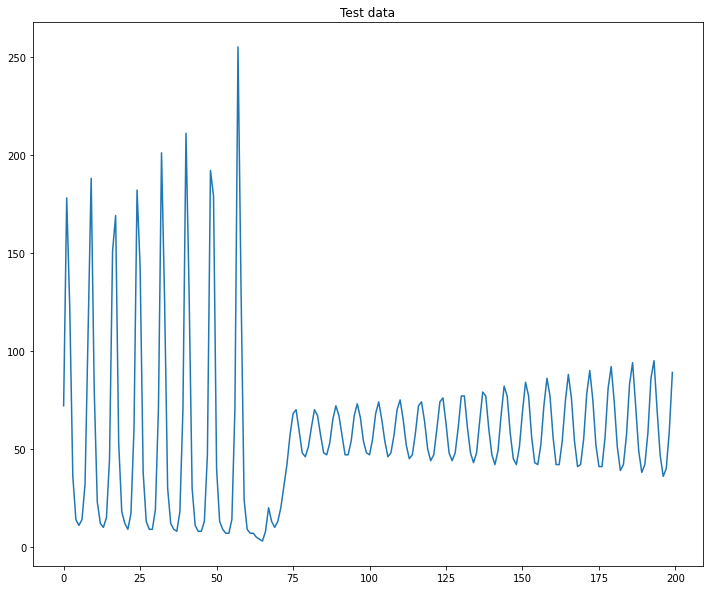

In [ ]:
plt.title('Test data')
plt.plot(test_df)
plt.plot
plt.show()

In [ ]:
a=df.iloc[930:].values.tolist()
b=test_df.values.tolist()

test_df = pd.DataFrame(a+b)
sc = MinMaxScaler()
scaler[0] = sc.fit(df.values)
test_scale = sc.transform(test_df.values)

lookback = 70
inputs_test = np.zeros((len(test_df)-lookback,lookback,df.shape[1]))
labels_test = np.zeros(len(test_df)-lookback)

for i in range(lookback, len(test_scale)):

    inputs_test[i-lookback] = test_scale[i-lookback:i]
    
    labels_test[i-lookback] = test_scale[i,0]
inputs_test = inputs_test.reshape(-1,lookback,df.shape[1])
labels_test = labels_test.reshape(-1,1)

pred_x={}
pred_y={}
pred_x[0]=inputs_test
pred_y[0]=labels_test

In [ ]:
pred_x[0].shape

(200, 70, 1)

In [ ]:
gru_outputs, targets,RMSE,MSE,MAE = predict(gru_model,pred_x, pred_y, scaler)

RMSE: 7.747447396968977
MSE: 60.02294116880138
MAE: 5.27160660147667


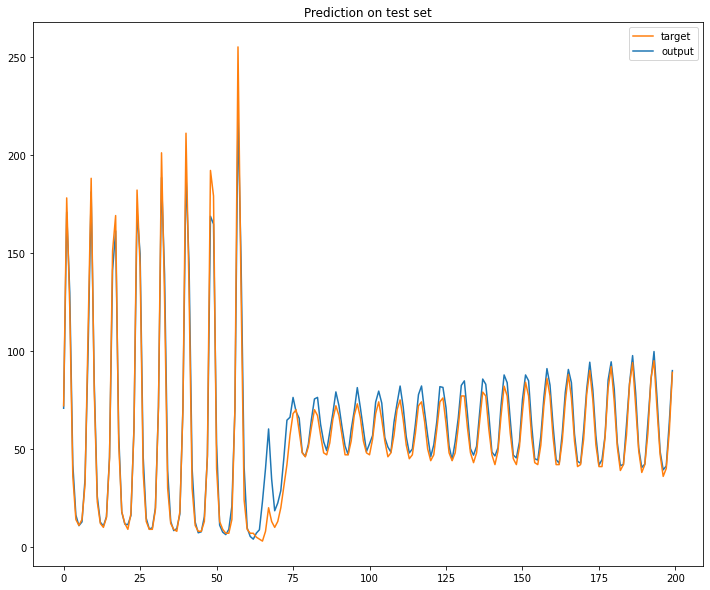

In [ ]:
plt.title('Prediction on test set')
p2=plt.plot(gru_outputs[0])
p1=plt.plot(targets[0])
plt.legend((p1[0], p2[0]), ('target', 'output'))
plt.show()

In [ ]:
featimp=[]

for i in range(19):
  df1=df
  df1=df1.drop(df1.columns[[0]], axis=1)
  values = df1.values
  values = values.astype('float32')
  scaler = MinMaxScaler(feature_range=(0, 1))
  scaled = scaler.fit_transform(values)
  reframed = series_to_supervised(scaled, 1, 1)
  reframed=pd.concat([reframed.iloc[:,0:19], reframed.iloc[:,-1]], axis=1)
  values = reframed.values
  frac = int(0.9*reframed.values.shape[0])
  train = values[:frac, :]
  test = values[frac:, :]
    
  train_X, train_y = train[:, :-1], train[:, -1]
  test_X, test_y = test[:, :-1], test[:, -1]

  train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
  test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))

  model = Sequential()
  model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
  model.add(Dense(1))
  model.compile(loss='mae', optimizer='adam')
    
  history = model.fit(train_X, train_y, epochs=5, batch_size=72, validation_data=(test_X, test_y), verbose=0, shuffle=False)
  
  yhat = model.predict(test_X)
  test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
      
  inv_yhat = np.concatenate((yhat, test_X[:, 1:]), axis=1)
  inv_yhat = scaler.inverse_transform(inv_yhat)
  inv_yhat = inv_yhat[:,0]
  
  test_y = test_y.reshape((len(test_y), 1))
  inv_y = np.concatenate((test_y, test_X[:, 1:]), axis=1)
  inv_y = scaler.inverse_transform(inv_y)
  inv_y = inv_y[:,0]
  mae=mean_absolute_error(inv_y, inv_yhat)
  featimp.append(mae)

In [ ]:
plt.title('Feature Importance Plot')
plt.bar(np.arange(19),featimp)
plt.xticks(np.arange(19), df.columns)
plt.xticks(rotation = 90)
plt.ylim(min(featimp)-2, max(featimp)+2)
plt.show()